# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way conbines unsupervised and supervised method. 

A classification model is trained under labelled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. The classification model will based on the pretrained model from supervised images and retrained with the categories labelled by the unsupervised methods.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary
from mylibs.save import save, load

import torch
from torchvision import transforms
import os

In [2]:
USE_GPU = False
BATCH_SIZE = 64
EPOCH = 10
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}

In [4]:
def whole_flow(mode, useResnet):
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    return eval_metrics

## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Start Training... Net
Epoch: 1
	Train      - Loss: 0.6007 Accuracy: 0.7893 F1_score: 0.7866
	Validation - Loss: 0.4469 Accuracy: 0.8388 F1_score: 0.8375
Epoch: 2
	Train      - Loss: 0.4159 Accuracy: 0.8487 F1_score: 0.8476
	Validation - Loss: 0.3953 Accuracy: 0.8598 F1_score: 0.8599
Epoch: 3
	Train      - Loss: 0.3700 Accuracy: 0.8654 F1_score: 0.8646
	Validation - Loss: 0.3673 Accuracy: 0.8700 F1_score: 0.8696
Epoch: 4
	Train      - Loss: 0.3397 Accuracy: 0.8770 F1_score: 0.8764
	Validation - Loss: 0.3555 Accuracy: 0.8707 F1_score: 0.8693
Epoch: 5
	Train      - Loss: 0.3184 Accuracy: 0.8859 F1_score: 0.8854
	Validation - Loss: 0.3486 Accuracy: 0.8762 F1_score: 0.8750
Epoch: 6
	Train      - Loss: 0.3011 Accuracy: 0.8919 F1_score: 0.8914
	Validation - Loss: 0.3418 Accuracy: 0.8788 F1_score: 0.8770
Epoch: 7
	Train      - Loss: 0.2858 Accuracy: 0.8994 F1_score: 0.8990
	Validation - Loss: 0.3345 Accu

<Figure size 432x288 with 0 Axes>

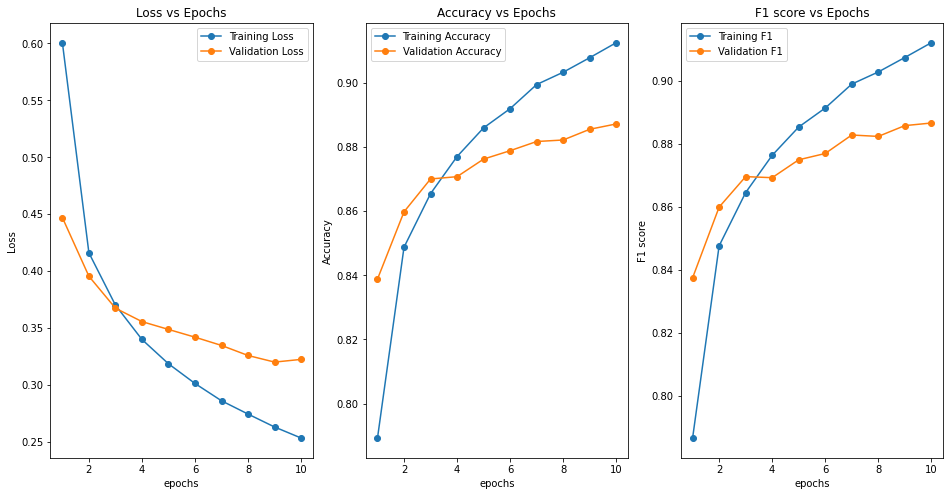

Loading model at epoch 10 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3478 Accuracy: 0.8736 F1_score: 0.8725
Result on unlabelled test set: Loss: 10.0432 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 3.2555 Accuracy: 0.6115 F1_score: 0.5270


In [5]:
mode_metric = whole_flow(6, False)
mode_metrics[6] = mode_metric

## Baseline #2, use full Fashion-MNIST dataset to train

Getting train and validate dataloaders for mode 7: use full FasionMNIST data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5418 Accuracy: 0.8197 F1_score: 0.8179
	Validation - Loss: 0.3825 Accuracy: 0.8605 F1_score: 0.8613
Epoch: 2
	Train      - Loss: 0.3588 Accuracy: 0.8753 F1_score: 0.8744
	Validation - Loss: 0.3366 Accuracy: 0.8755 F1_score: 0.8765
Epoch: 3
	Train      - Loss: 0.3188 Accuracy: 0.8882 F1_score: 0.8876
	Validation - Loss: 0.3118 Accuracy: 0.8858 F1_score: 0.8852
Epoch: 4
	Train      - Loss: 0.2936 Accuracy: 0.8974 F1_score: 0.8969
	Validation - Loss: 0.2975 Accuracy: 0.8902 F1_score: 0.8896
Epoch: 5
	Train      - Loss: 0.2745 Accuracy: 0.9047 F1_score: 0.9043
	Validation - Loss: 0.2861 Accuracy: 0.8935 F1_score: 0.8915
Epoch: 6
	Train      - Loss: 0.2588 Accuracy: 0.9100 F1_score: 0.9096
	Validation - Loss: 0.2781 Accuracy: 0.8957 F1_score: 0.8953
Epoch: 7
	Train      - Loss: 0.2469 Accuracy: 0.9137 F1_score: 0.9134
	Validation - Loss: 0.2751 Accuracy: 0.8988 F

<Figure size 432x288 with 0 Axes>

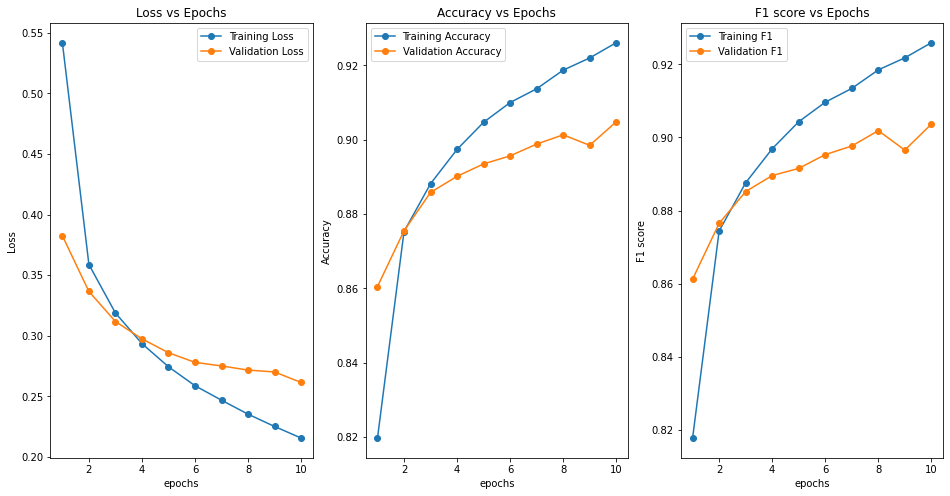

Loading model at epoch 10 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3539 Accuracy: 0.8720 F1_score: 0.8742
Result on unlabelled test set: Loss: 0.1136 Accuracy: 0.9650 F1_score: 0.9727
Result on full test set      : Loss: 0.2838 Accuracy: 0.8999 F1_score: 0.8989


In [6]:
mode_metric = whole_flow(7, False)
mode_metrics[7] = mode_metric

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

## Approach #2, use KMeans with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 1: clustering: kmeans with PCA
Labeling unlabeled data...
Labeling accuracy: 0.881
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5386 Accuracy: 0.8186 F1_score: 0.8165
	Validation - Loss: 0.4001 Accuracy: 0.8568 F1_score: 0.8533
Epoch: 2
	Train      - Loss: 0.3624 Accuracy: 0.8723 F1_score: 0.8714
	Validation - Loss: 0.3542 Accuracy: 0.8708 F1_score: 0.8680
Epoch: 3
	Train      - Loss: 0.3220 Accuracy: 0.8863 F1_score: 0.8856
	Validation - Loss: 0.3256 Accuracy: 0.8847 F1_score: 0.8845
Epoch: 4
	Train      - Loss: 0.2960 Accuracy: 0.8969 F1_score: 0.8963
	Validation - Loss: 0.3112 Accuracy: 0.8902 F1_score: 0.8898
Epoch: 5
	Train      - Loss: 0.2766 Accuracy: 0.9035 F1_score: 0.9031
	Validation - Loss: 0.2994 Accuracy: 0.8950 F1_score: 0.8949
Epoch: 6
	Train      - Loss: 0.2612 Accuracy: 0.9085 F1_score: 0.9081
	Validation - Loss: 0.2888 Accuracy: 0.8970 F1_score: 0.8961
Epoch: 7
	Train      - Loss: 0.2475 Accuracy: 0.9145 F1_score

<Figure size 432x288 with 0 Axes>

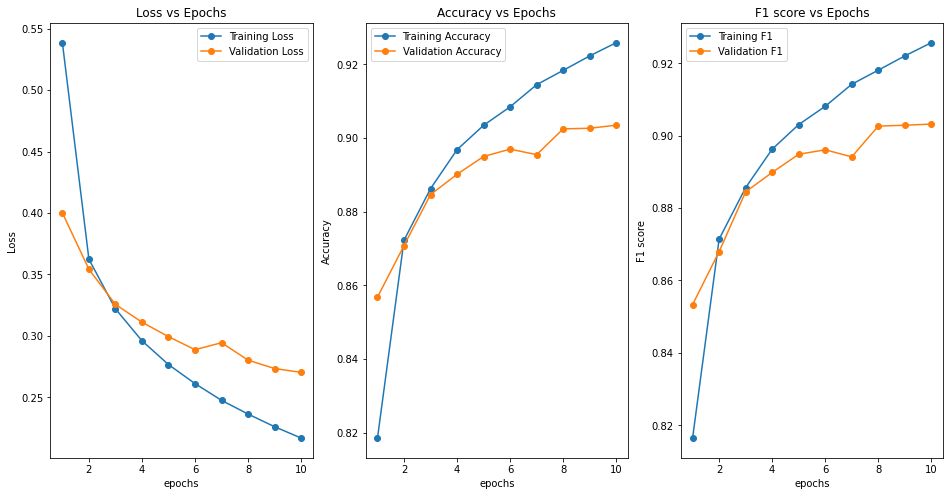

Loading model at epoch 10 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3722 Accuracy: 0.8654 F1_score: 0.8709
Result on unlabelled test set: Loss: 0.5602 Accuracy: 0.8753 F1_score: 0.8841
Result on full test set      : Loss: 0.4318 Accuracy: 0.8684 F1_score: 0.8694


In [5]:
mode_metric = whole_flow(1, False)
mode_metrics[2] = mode_metric

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

In [5]:
mode_metric = whole_flow(2, False)
mode_metrics[2] = mode_metric

Getting train and validate dataloaders for mode 2: clustering: kmeans with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/modules/conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Epoch: 1 Loss: {'loss': 0.6892773025201014}
Epoch: 2 Loss: {'loss': 0.6859798306470231}
Epoch: 3 Loss: {'loss': 0.6859346521260683}
Epoch: 4 Loss: {'loss': 0.6859299871891896}
Epoch: 5 Loss: {'loss': 0.6859020433036302}
Epoch: 6 Loss: {'loss': 0.6859054240409689}
Epoch: 7 Loss: {'loss': 0.6859045087973559}
Epoch: 8 Loss: {'loss': 0.6858995532481328}
Epoch: 9 Loss: {'loss': 0.6858989054313985}
Epoch: 10 Loss: {'loss': 0.6858903946715604}
Epoch: 11 Loss: {'loss': 0.6858964884259985}
Epoch: 12 Loss: {'loss': 0.6858891554666455}
Epoch: 13 Loss: {'loss': 0.6858916156668858}
Epoch: 14 Loss: {'loss': 0.6858904178570261}
Epoch: 15 Loss: {'loss': 0.6858923923270529}
Epoch: 16 Loss: {'loss': 0.6858854541558356}
Epoch: 17 Loss: {'loss': 0.6858789842463302}
Epoch: 18 Loss: {'loss': 0.6858797223699241}
Epoch: 19 Loss: {'loss': 0.6858860142065831}
Epoch: 20 Loss: {'loss': 0.685877865627011}
Epoch: 21 Loss: {'loss': 0.6858764533251259}
Epoch: 22 Loss: {'loss': 0.6858761425975373}
Epoch: 23 Loss: {'lo

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

<Figure size 432x288 with 0 Axes>

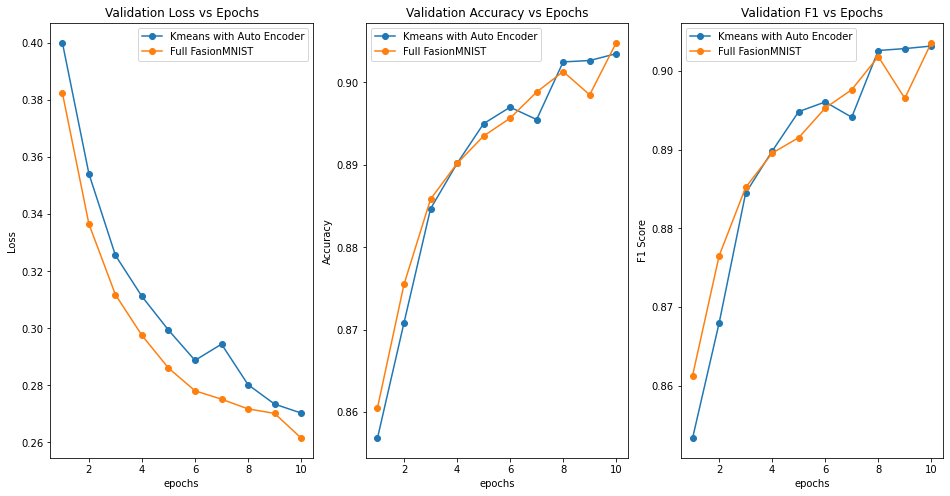

In [7]:
report_summary(mode_metrics, mode_description_short)

## Conclusion